In [114]:
import keras, keras.backend as K
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Conv2DTranspose
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
#Load the Data into Training and Validation Set
(X_train, y_train), (X_val, y_val) = cifar10.load_data()
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

print("Training samples:", X_train.shape, y_train.shape)
print("Testing samples:", X_val.shape, y_val.shape)

Training samples: (50000, 32, 32, 3) (50000, 1)
Testing samples: (10000, 32, 32, 3) (10000, 1)


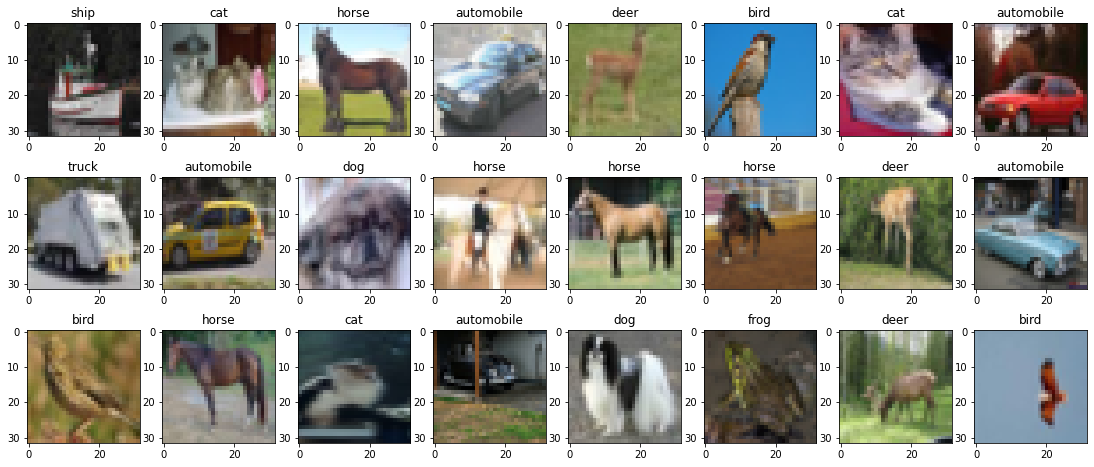

In [116]:
#Display Random Images from Training Data
columns = 8
rows = 3
fig = plt.figure(figsize=(2.5 * columns - 1, 3 * rows - 1))
for i in range(columns):
    for j in range(rows):
        rand_idx = np.random.randint(0, X_train.shape[0])
        axis = fig.add_subplot(rows, columns, i * rows + j + 1)
        axis.imshow(X_train[rand_idx, :])
        axis.set_title(cifar10_classes[y_train[rand_idx, 0]])
plt.show()

In [117]:
#Normalize Images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [118]:
#Image Dimension
IMAGE_DIM=X_train.shape[1:]

#Required Feature vector size after encoding
ENCODED_SIZE=512

def ConvAutoEncoder(img_dim, encoded_size):
    #Encoder Part
    enc = keras.models.Sequential()
    enc.add(InputLayer(img_dim))
    enc.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    enc.add(MaxPooling2D(pool_size=(2, 2)))
    enc.add(Flatten())
    enc.add(Dense(encoded_size)) 

    #Decoder Part
    dec = keras.models.Sequential()
    dec.add(InputLayer((encoded_size,)))
    dec.add(Dense(4096))
    dec.add(Reshape((8,8,64)))
    dec.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    dec.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))

    return enc, dec

encoder, decoder = ConvAutoEncoder(img_dim=IMAGE_DIM, encoded_size=ENCODED_SIZE)

In [119]:
#Print Summary
encoder.summary()
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2097664   
Total params: 2,117,056
Trainable params: 2,117,056
Non-trainable params: 0
____________________________________________

In [120]:
input = Input(IMAGE_DIM)
encoded = encoder(input)
decoded = decoder(encoded)

cae = keras.models.Model(inputs=input, outputs=decoded)
cae.compile(optimizer='adamax', loss='mean_squared_error')

In [121]:
cae.fit(X_train, X_train, batch_size=16, epochs=50, verbose=1, validation_data=(X_val, X_val))

Epoch 1/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0122 - val_loss: 0.0060
Epoch 2/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 3/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 6/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 8/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 9/50
3125/3125 [==============================] - 21s 7ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/50
3125/3125 [==============================] - 21s 7ms/step - l

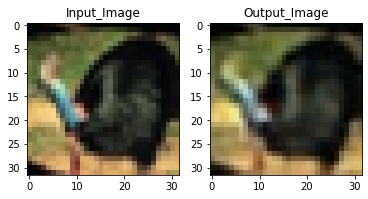

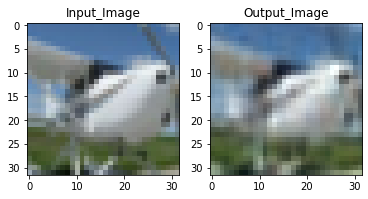

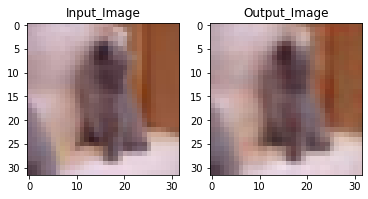

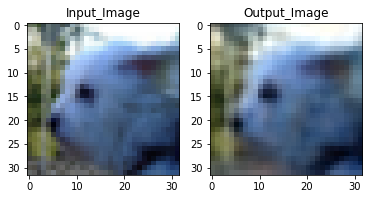

In [122]:
def show_image(x):
    plt.imshow(np.clip(x, 0, 1))

def display_input_output(image):
  encoded_vector = encoder.predict(image[np.newaxis, :])[0]
  decoded_image = decoder.predict(encoded_vector[np.newaxis, :])[0]

  plt.subplot(1,2,1)
  plt.title("Input_Image")
  show_image(image)

  plt.subplot(1,2,2)
  plt.title("Output_Image")
  show_image(decoded_image)
  
  plt.show()

#Display Random Val Images with both Input_Image as well as Reconstructed/Decoded Image
for i in range(4):
  rand_idx = np.random.randint(0, X_val.shape[0])
  test_image = X_val[rand_idx]
  display_input_output(test_image)

In [123]:
#Save model for later use
cae.save('convAutoEncoder.h5')